<a href="https://colab.research.google.com/github/lujain618/Deepfake_Detection_With_XAI/blob/main/InputPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install remotezip tqdm opencv-python

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -U "tensorflow>=2.10.0"

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import cv2
import numpy as np
import remotezip as rz
import tensorflow as tf
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from pathlib import Path

In [ ]:
def load_frames_from_video(video_folder):
    video_folder = pathlib.Path(video_folder)
    frame_files = sorted(video_folder.glob("*.npy"))
    frames = [np.load(frame) for frame in frame_files]
    frames_array = np.stack(frames, axis=0)
    return frames_array


In [ ]:
dataset_path = Path("/content/drive/My Drive/DeepfakeDataset/train_processed")
video_path = dataset_path / "0" / "00000"
print(os.listdir(dataset_path))

['0', '1']


In [ ]:
video_frames = load_frames_from_video(video_path)
video_frames.shape

(30, 112, 112, 3)

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


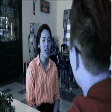

In [ ]:
to_gif(video_frames)

In [ ]:
class FrameGenerator:
  def __init__(self, path, training = False):

    self.path = pathlib.Path(path)
    self.training = training
    self.class_names = sorted([p.name for p in self.path.iterdir() if p.is_dir()])
    self.class_ids_for_name = {name: int(name) for name in self.class_names}

  def get_video_folders_and_labels(self):
    video_folders = list(self.path.glob("*/*"))
    labels = [p.parent.name for p in video_folders]
    return video_folders, labels

  def __call__(self):
    video_folders, labels = self.get_video_folders_and_labels()

    pairs = list(zip(video_folders, labels))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = load_frames_from_video(path)
      label = self.class_ids_for_name[name]
      yield video_frames, label

In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(dataset_path, training=False),
                                          output_signature = output_signature)

In [ ]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Shape of training set of frames: (30, 112, 112, 3)
Shape of training labels: ()


In [ ]:
val_path = Path("/content/drive/My Drive/DeepfakeDataset/val_processed")
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path, 10),
                                        output_signature = output_signature)
test_path = Path("/content/drive/My Drive/DeepfakeDataset/test_processed")
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, 10),
                                        output_signature = output_signature)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(300).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size = AUTOTUNE)

In [ ]:
train_ds = train_ds.batch(16)
val_ds = val_ds.batch(16)
test_ds = test_ds.batch(16)

In [ ]:
frames_list = []
labels_list = []

for frames, labels in test_ds:
    frames_list.append(frames.numpy())
    labels_list.append(labels.numpy())

np.savez_compressed("/content/test_ds.npz", frames=np.concatenate(frames_list), labels=np.concatenate(labels_list))

!cp /content/test_ds.npz /content/drive/MyDrive/

In [ ]:
frames_list = []
labels_list = []

for frames, labels in train_ds:
    frames_list.append(frames.numpy())
    labels_list.append(labels.numpy())

np.savez_compressed("/content/train_ds.npz", frames=np.concatenate(frames_list), labels=np.concatenate(labels_list))

!cp /content/train_ds.npz /content/drive/MyDrive/

In [ ]:
frames_list = []
labels_list = []

for frames, labels in val_ds:
    frames_list.append(frames.numpy())
    labels_list.append(labels.numpy())

np.savez_compressed("/content/val_ds.npz", frames=np.concatenate(frames_list), labels=np.concatenate(labels_list))

!cp /content/val_ds.npz /content/drive/MyDrive/